## Select seed

In [1]:
import sys
my_seed = 0 # int(sys.argv[1])

## Multiplicative factor on the number of users n to augment training data

In [2]:
attack = 'NK'
aug_factor_syn_profiles = 1 # nb of synthetic profiles to generate * n

## Functions to save results in csv format per method

In [3]:
def write_rs_fd_grr(values):
        with open('results/adults/attack_'+str(attack)+'_s_'+str(aug_factor_syn_profiles)+'_rs_fd_grr.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()
        
def write_rs_fd_oue_z(values):
        with open('results/adults/attack_'+str(attack)+'_s_'+str(aug_factor_syn_profiles)+'_rs_fd_oue_z.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()        

def write_rs_fd_oue_r(values):
        with open('results/adults/attack_'+str(attack)+'_s_'+str(aug_factor_syn_profiles)+'_rs_fd_oue_r.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()     
        
def write_rs_fd_sue_z(values):
        with open('results/adults/attack_'+str(attack)+'_s_'+str(aug_factor_syn_profiles)+'_rs_fd_sue_z.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()        

def write_rs_fd_sue_r(values):
        with open('results/adults/attack_'+str(attack)+'_s_'+str(aug_factor_syn_profiles)+'_rs_fd_sue_r.csv', mode='a', newline='') as scores_file:
            scores_writer = csv.writer(scores_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            scores_writer.writerow(values)
        scores_file.close()           

## Numba library for speeding up things

In [4]:
from numba import jit

C:\Users\heber\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\heber\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\heber\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## GRR function

In [5]:
@jit(nopython=True)
def GRR(x, lst_val, p, q):
    """
    GRR mechanism
    input: true value x, domain values 'lst_val', and probabilities p,q
    output: true value w.p. 'p', random value (except x) w.p. 'q'
    """
    
    rnd = np.random.random()

    if rnd <=p:    
        return x
    else:
        return np.random.choice(lst_val[lst_val !=x]) 

## UE function

In [6]:
@jit(nopython=True)
def UE(arr, p, q):
    """
    UE mechanism
    input: encoded true value arr and probabilities p and q
    output: sanitized array 'rep'
    """
    
    size = len(arr) #domain size
    rep = np.zeros(size) # initialize zero-vector
    
    for ind in range(size): # for each bit
        if arr[ind] != 1:
            rnd = np.random.random()
            if rnd <= q:
                rep[ind] = 1       
        else:
            rnd = np.random.random()
            if rnd <= p:
                rep[ind] = 1
    return rep

## Main libraries

In [7]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import copy
import time
import csv
from pandas.core.common import flatten

#ML
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## Import estimators

In [8]:
from estimators_rspfd import SB_RSpFD_GRR, SB_RSpFD_UE, SB_RSpFD_UE_Zero

## Reading dataset

In [20]:
df = pd.read_csv('db_Adult.csv')
# df = df.sample(frac=0.1)
# df.reset_index(inplace=True, drop=True)
df

,age,workclass,education,marital-status,occupation,relationship,race,sex,native-country,salary
0,40,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K
1,40,Private,Some-college,Married-civ-spouse,Tech-support,Husband,White,Male,United-States,>50K
2,28,Private,Masters,Divorced,Prof-specialty,Not-in-family,White,Female,United-States,<=50K
3,40,Self-emp-not-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,>50K
4,41,Private,HS-grad,Divorced,Machine-op-inspct,Own-child,White,Male,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...
4517,64,State-gov,Doctorate,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,>50K
4518,28,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
4519,31,Private,HS-grad,Never-married,Prof-specialty,Not-in-family,White,Male,United-States,<=50K
4520,29,Private,Bachelors,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,<=50K


## Dataset to work with

In [10]:
attributes = list(df.columns)

LE = LabelEncoder()

for col in attributes:
    df[col] = LE.fit_transform(df[col])
df

,age,workclass,education,marital-status,occupation,relationship,race,sex,native-country,salary
0,4,2,14,3,0,3,2,0,20,0
1,4,2,7,3,13,3,4,1,20,0
2,17,2,6,3,9,1,4,1,20,0
3,10,2,1,2,11,3,1,1,10,0
4,13,2,4,4,5,1,4,1,20,0
...,...,...,...,...,...,...,...,...,...,...
447,28,2,10,4,7,1,4,0,20,0
448,20,2,14,1,3,0,4,1,20,0
449,28,2,10,3,0,1,4,1,20,0
450,19,2,0,1,2,0,4,1,20,0


## Static parameters

In [11]:
#number of dimensions (d)
d = len(attributes)
print('d=', d)

#number of users (n)
n = df.shape[0]
print('n=',n)

#sampling rate
beta = 1/d
print('beta=', beta)

#domain size of attributse
lst_k = [len(df[att].unique()) for att in attributes]
print('Domain size of attributes =', lst_k)

#range of epsilon used in experiments
lst_eps = list(range(1, 11))
print('epsilon=', lst_eps)

d= 10
n= 452
beta= 0.1
Domain size of attributes = [57, 6, 15, 6, 14, 6, 5, 2, 21, 2]
epsilon= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## RS+FD[GRR]

In [12]:
starttime = time.time()

dic_rsfd_grr = {} # initialize dictionary to save df result per epsilon


print(my_seed)

np.random.seed(my_seed)

lst_acc = []
for epsilon_tot in lst_eps: #iterate over each epsilon value

    dic_id = {key:[] for key in range(n)}

    est_rs_fd = {}

    eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

    # we'll shuffle the users' order in the dataset
    dff = df.sample(frac=1)     
    dff.reset_index(drop=True, inplace=True)

    # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
    lst_index = [list(_) for _ in np.array_split(dff.index, d)]

    for index_att in range(d): # for each attribute

        att = attributes[index_att]

        k = lst_k[index_att]
        
        lst_val = np.arange(k) # take domain values of the attribute

        # select users that report the true value of this attribute (i.e., not fake data)
        lst_true = {key:val for key, val in dff.iloc[lst_index[index_att]][att].iteritems()} 

        # GRR parameters with amplified epsilon (eps_l)
        p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
        q = (1 - p) / (k - 1)

        for usr_id in dic_id.keys():

            if usr_id in lst_index[index_att]:
                dic_id[usr_id].append(GRR(lst_true[usr_id], lst_val, p, q))

            else:
                dic_id[usr_id].append(np.random.randint(k))

        est_rs_fd[att] = SB_RSpFD_GRR(np.array(list(dic_id.values()))[:,index_att], p, q, lst_val, d, k, n)

    # Attacking part

    dic_id_syn = {}
    for _ in range(aug_factor_syn_profiles*n):

        profile = np.zeros(d+1)
        smp_att = np.random.randint(d)

        for index_att in range(d):
            att = attributes[index_att]

            k = lst_k[index_att]
        
            lst_val = np.arange(k) # take domain values of the attribute

            if index_att != smp_att:
                profile[index_att] = np.random.randint(k)
            else:
                # GRR parameters with amplified epsilon (eps_l)
                p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
                q = (1 - p) / (k - 1)

                #following estimated distributions
                profile[smp_att] = GRR(np.random.choice(lst_val, p=est_rs_fd[att]), lst_val, p, q)
        profile[-1] = smp_att
        dic_id_syn[_] = profile.astype(int)

    df_train = pd.DataFrame.from_dict(dic_id_syn, orient='index')
    df_train.columns = attributes + ['Smp_Att']
    df_train = df_train.sample(frac=1)
    df_train.reset_index(drop=True, inplace=True)

    x_train = df_train.drop('Smp_Att', axis = 1)
    y_train = df_train['Smp_Att']


    # test on collected profiles
    lst_label = [i for i in range(d) for _ in range(len(lst_index[i]))]
    df_test = pd.DataFrame.from_dict(dic_id.values())
    df_test.columns = attributes 
    df_test['Smp_Att'] = lst_label
    df_test = df_test.sample(frac=1)
    df_test.reset_index(drop=True, inplace=True)

    x_test = df_test.drop('Smp_Att', axis = 1)
    y_test = df_test['Smp_Att']

    model = XGBClassifier(random_state=my_seed, n_jobs=-1, eval_metric='mlogloss')
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test,y_pred)*100, 2)

    lst_acc.append(acc)

dic_rsfd_grr[my_seed] = lst_acc
#     #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
write_rs_fd_grr(list(flatten([my_seed, lst_acc])))

print('That took {} seconds'.format(time.time() - starttime))    

0
That took 8.796671867370605 seconds


## RS+FD[OUE-0]

In [13]:
starttime = time.time()

dic_rsfd_oue_z = {} # initialize dictionary to save df result per epsilon


print(my_seed)

np.random.seed(my_seed)

lst_acc = []
for epsilon_tot in lst_eps: #iterate over each epsilon value

    dic_id = {key:[] for key in range(n)}

    est_rs_fd = {}

    eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

    # we'll shuffle the users' order in the dataset
    dff = df.sample(frac=1)     
    dff.reset_index(drop=True, inplace=True)

    # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
    lst_index = [list(_) for _ in np.array_split(dff.index, d)]

    for index_att in range(d): # for each attribute

        att = attributes[index_att]

        k = lst_k[index_att]
        
        lst_val = np.eye(k) # take domain values of the attribute

        # select users that report the true value of this attribute (i.e., not fake data)
        lst_true = {key:val for key, val in dff.iloc[lst_index[index_att]][att].iteritems()} 

        # OUE parameters with amplified epsilon (eps_l)
        p = 1/2
        q = 1 / (np.exp(eps_l) + 1)

        zero_vec = np.zeros(k) #initialize zero vector

        # randomize data of 'real' users and generate fake data for the rest
        for usr_id in dic_id.keys():

            if usr_id in lst_index[index_att]:
                dic_id[usr_id].append(UE(lst_val[lst_true[usr_id]], p, q))

            else:
                dic_id[usr_id].append(UE(zero_vec, p, q))

        est_rs_fd[att] = SB_RSpFD_UE_Zero(np.array(list(dic_id.values()))[:,index_att], p, q, d, k, n)

    # Attacking part

    dic_id_syn = {}
    for _ in range(aug_factor_syn_profiles*n):

        profile = np.array([])
        smp_att = np.random.randint(d)

        for index_att in range(d):
            att = attributes[index_att]

            k = lst_k[index_att]
        
            lst_val = np.eye(k) # take domain values of the attribute

            # OUE parameters with amplified epsilon (eps_l)
            p = 1/2
            q = 1 / (np.exp(eps_l) + 1)

            zero_vec = np.zeros(k) #initialize zero vector

            if index_att != smp_att:
                profile = np.concatenate([profile, UE(zero_vec, p, q)])
            else:
                #following estimated distribution
                profile = np.concatenate([profile, UE(lst_val[np.random.choice(range(k), p=est_rs_fd[att])], p, q) ]) 
        profile = np.concatenate([profile, [smp_att]])
        dic_id_syn[_] = profile.astype(int)

    df_train = pd.DataFrame.from_dict(np.array([dic_id_syn[val] for val in range(aug_factor_syn_profiles*n)]))
    df_train.rename({df_train.shape[1]-1:'Smp_Att'}, axis=1, inplace=True)
    df_train = df_train.sample(frac=1)
    df_train.reset_index(drop=True, inplace=True)

    x_train = df_train.drop('Smp_Att', axis = 1)
    y_train = df_train['Smp_Att']

    # test on collected profiles
    lst_label = [i for i in range(d) for _ in range(len(lst_index[i]))]
    df_test = pd.DataFrame.from_dict([np.concatenate(dic_id[val]) for val in range(n)])
    df_test['Smp_Att'] = lst_label
    df_test = df_test.sample(frac=1)
    df_test.reset_index(drop=True, inplace=True)

    x_test = df_test.drop('Smp_Att', axis = 1)
    y_test = df_test['Smp_Att']

    model = XGBClassifier(random_state=my_seed, n_jobs=-1, eval_metric='mlogloss')
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test,y_pred)*100, 2)
    lst_acc.append(acc)

dic_rsfd_oue_z[my_seed] = lst_acc
#     #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
write_rs_fd_oue_z(list(flatten([my_seed, lst_acc])))
    
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 8.743586778640747 seconds


## RS+FD[OUE-R]

In [14]:
starttime = time.time()

dic_rsfd_oue_r = {} # initialize dictionary to save df result per epsilon

print(my_seed)

np.random.seed(my_seed)

lst_acc = []
for epsilon_tot in lst_eps: #iterate over each epsilon value

    dic_id = {key:[] for key in range(n)}

    est_rs_fd = {}

    eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

    # we'll shuffle the users' order in the dataset
    dff = df.sample(frac=1)     
    dff.reset_index(drop=True, inplace=True)

    # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
    lst_index = [list(_) for _ in np.array_split(dff.index, d)]

    for index_att in range(d): # for each attribute

        att = attributes[index_att]

        k = lst_k[index_att]
        
        lst_val = np.eye(k) # take domain values of the attribute

        # select users that report the true value of this attribute (i.e., not fake data)
        lst_true = {key:val for key, val in dff.iloc[lst_index[index_att]][att].iteritems()} 

        # OUE parameters with amplified epsilon (eps_l)
        p = 1/2
        q = 1 / (np.exp(eps_l) + 1)

        # randomize data of 'real' users and generate fake data for the rest
        for usr_id in dic_id.keys():

            if usr_id in lst_index[index_att]:
                dic_id[usr_id].append(UE(lst_val[lst_true[usr_id]], p, q))

            else:
                dic_id[usr_id].append(UE(lst_val[np.random.randint(k)], p, q))

        est_rs_fd[att] = SB_RSpFD_UE(np.array(list(dic_id.values()))[:,index_att], p, q, d, k, n)

    # Attacking part

    dic_id_syn = {}
    for _ in range(aug_factor_syn_profiles*n):

        profile = np.array([])
        smp_att = np.random.randint(d)

        for index_att in range(d):
            att = attributes[index_att]

            k = lst_k[index_att]
        
            lst_val = np.eye(k) # take domain values of the attribute

            # OUE parameters with amplified epsilon (eps_l)
            p = 1/2
            q = 1 / (np.exp(eps_l) + 1)

            if index_att != smp_att:
                profile = np.concatenate([profile, UE(lst_val[np.random.randint(k)], p, q)])
            else:
                #following estimated distribution
                profile = np.concatenate([profile, UE(lst_val[np.random.choice(range(k), p=est_rs_fd[att])], p, q) ]) 
        profile = np.concatenate([profile, [smp_att]])
        dic_id_syn[_] = profile.astype(int)

    df_train = pd.DataFrame.from_dict(np.array([dic_id_syn[val] for val in range(aug_factor_syn_profiles*n)]))
    df_train.rename({df_train.shape[1]-1:'Smp_Att'}, axis=1, inplace=True)
    df_train = df_train.sample(frac=1)
    df_train.reset_index(drop=True, inplace=True)

    x_train = df_train.drop('Smp_Att', axis = 1)
    y_train = df_train['Smp_Att']


    # test on collected profiles
    lst_label = [i for i in range(d) for _ in range(len(lst_index[i]))]
    df_test = pd.DataFrame.from_dict([np.concatenate(dic_id[val]) for val in range(n)])
    df_test['Smp_Att'] = lst_label
    df_test = df_test.sample(frac=1)
    df_test.reset_index(drop=True, inplace=True)

    x_test = df_test.drop('Smp_Att', axis = 1)
    y_test = df_test['Smp_Att']

    model = XGBClassifier(random_state=my_seed, n_jobs=-1, eval_metric='mlogloss')
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test,y_pred)*100, 2)
    lst_acc.append(acc)

dic_rsfd_oue_r[my_seed] = lst_acc
#     #write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
write_rs_fd_oue_r(list(flatten([my_seed, lst_acc])))
    
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 14.023013591766357 seconds


## RS+FD[SUE-z]

In [15]:
starttime = time.time()

dic_rsfd_oue_z = {} # initialize dictionary to save df result per epsilon

print(my_seed)

np.random.seed(my_seed)

lst_acc = []
for epsilon_tot in lst_eps: #iterate over each epsilon value

    dic_id = {key:[] for key in range(n)}

    est_rs_fd = {}

    eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

    # SUE parameters with amplified epsilon (eps_l)
    p = np.exp(eps_l/2) / (np.exp(eps_l/2) + 1)
    q = 1 / (np.exp(eps_l/2) + 1)

    # we'll shuffle the users' order in the dataset
    dff = df.sample(frac=1)     
    dff.reset_index(drop=True, inplace=True)

    # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
    lst_index = [list(_) for _ in np.array_split(dff.index, d)]

    for index_att in range(d): # for each attribute

        att = attributes[index_att]

        k = lst_k[index_att]

        lst_val = np.eye(k) # take domain values of the attribute

        # select users that report the true value of this attribute (i.e., not fake data)
        lst_true = {key:val for key, val in dff.iloc[lst_index[index_att]][att].iteritems()} 

        zero_vec = np.zeros(k) #initialize zero vector

        # randomize data of 'real' users and generate fake data for the rest
        for usr_id in dic_id.keys():

            if usr_id in lst_index[index_att]:
                dic_id[usr_id].append(UE(lst_val[lst_true[usr_id]], p, q))

            else:
                dic_id[usr_id].append(UE(zero_vec, p, q))

        est_rs_fd[att] = SB_RSpFD_UE_Zero(np.array(list(dic_id.values()))[:,index_att], p, q, d, k, n)

    # Attacking part

    dic_id_syn = {}
    for _ in range(aug_factor_syn_profiles*n):

        profile = np.array([])
        smp_att = np.random.randint(d)

        for index_att in range(d):
            att = attributes[index_att]

            k = lst_k[index_att]

            lst_val = np.eye(k) # take domain values of the attribute

            # OUE parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l/2) / (np.exp(eps_l/2) + 1)
            q = 1 / (np.exp(eps_l/2) + 1)

            zero_vec = np.zeros(k) #initialize zero vector

            if index_att != smp_att:
                profile = np.concatenate([profile, UE(zero_vec, p, q)])
            else:
                #following estimated distribution
                profile = np.concatenate([profile, UE(lst_val[np.random.choice(range(k), p=est_rs_fd[att])], p, q) ]) 
        profile = np.concatenate([profile, [smp_att]])
        dic_id_syn[_] = profile.astype(int)

    df_train = pd.DataFrame.from_dict(np.array([dic_id_syn[val] for val in range(aug_factor_syn_profiles*n)]))
    df_train.rename({df_train.shape[1]-1:'Smp_Att'}, axis=1, inplace=True)
    df_train = df_train.sample(frac=1)
    df_train.reset_index(drop=True, inplace=True)

    x_train = df_train.drop('Smp_Att', axis = 1)
    y_train = df_train['Smp_Att']

    # test on collected profiles
    lst_label = [i for i in range(d) for _ in range(len(lst_index[i]))]
    df_test = pd.DataFrame.from_dict([np.concatenate(dic_id[val]) for val in range(n)])
    df_test['Smp_Att'] = lst_label
    df_test = df_test.sample(frac=1)
    df_test.reset_index(drop=True, inplace=True)

    x_test = df_test.drop('Smp_Att', axis = 1)
    y_test = df_test['Smp_Att']

    model = XGBClassifier(random_state=my_seed, n_jobs=-1, eval_metric='mlogloss')
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test,y_pred)*100, 2)
    lst_acc.append(acc)

dic_rsfd_oue_z[my_seed] = lst_acc
#write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
write_rs_fd_sue_z(list(flatten([my_seed, lst_acc])))
    
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 11.38973593711853 seconds


## RS+FD[SUE-r]

In [16]:
starttime = time.time()

dic_rsfd_oue_r = {} # initialize dictionary to save df result per epsilon

print(my_seed)

np.random.seed(my_seed)

lst_acc = []
for epsilon_tot in lst_eps: #iterate over each epsilon value

    dic_id = {key:[] for key in range(n)}

    est_rs_fd = {}

    eps_l = np.log((np.exp(epsilon_tot) - 1 + beta)/beta) #amplification by sampling

    # SUE parameters with amplified epsilon (eps_l)
    p = np.exp(eps_l/2) / (np.exp(eps_l/2) + 1)
    q = 1 / (np.exp(eps_l/2) + 1)

    # we'll shuffle the users' order in the dataset
    dff = df.sample(frac=1)     
    dff.reset_index(drop=True, inplace=True)

    # we'll partitionate the users indexes to separate in groups (i.e., to report a single attribute)
    lst_index = [list(_) for _ in np.array_split(dff.index, d)]

    for index_att in range(d): # for each attribute

        att = attributes[index_att]

        k = lst_k[index_att]

        lst_val = np.eye(k) # take domain values of the attribute

        # select users that report the true value of this attribute (i.e., not fake data)
        lst_true = {key:val for key, val in dff.iloc[lst_index[index_att]][att].iteritems()} 

        # randomize data of 'real' users and generate fake data for the rest
        for usr_id in dic_id.keys():

            if usr_id in lst_index[index_att]:
                dic_id[usr_id].append(UE(lst_val[lst_true[usr_id]], p, q))

            else:
                dic_id[usr_id].append(UE(lst_val[np.random.randint(k)], p, q))

        est_rs_fd[att] = SB_RSpFD_UE(np.array(list(dic_id.values()))[:,index_att], p, q, d, k, n)

    # Attacking part

    dic_id_syn = {}
    for _ in range(aug_factor_syn_profiles*n):

        profile = np.array([])
        smp_att = np.random.randint(d)

        for index_att in range(d):
            att = attributes[index_att]

            k = lst_k[index_att]

            lst_val = np.eye(k) # take domain values of the attribute

            # OUE parameters with amplified epsilon (eps_l)
            p = np.exp(eps_l/2) / (np.exp(eps_l/2) + 1)
            q = 1 / (np.exp(eps_l/2) + 1)

            zero_vec = np.zeros(k) #initialize zero vector

            if index_att != smp_att:
                profile = np.concatenate([profile, UE(zero_vec, p, q)])
            else:
                #following estimated distribution
                profile = np.concatenate([profile, UE(lst_val[np.random.choice(range(k), p=est_rs_fd[att])], p, q) ]) 
        profile = np.concatenate([profile, [smp_att]])
        dic_id_syn[_] = profile.astype(int)

    df_train = pd.DataFrame.from_dict(np.array([dic_id_syn[val] for val in range(aug_factor_syn_profiles*n)]))
    df_train.rename({df_train.shape[1]-1:'Smp_Att'}, axis=1, inplace=True)
    df_train = df_train.sample(frac=1)
    df_train.reset_index(drop=True, inplace=True)

    x_train = df_train.drop('Smp_Att', axis = 1)
    y_train = df_train['Smp_Att']

    # test on collected profiles
    lst_label = [i for i in range(d) for _ in range(len(lst_index[i]))]
    df_test = pd.DataFrame.from_dict([np.concatenate(dic_id[val]) for val in range(n)])
    df_test['Smp_Att'] = lst_label
    df_test = df_test.sample(frac=1)
    df_test.reset_index(drop=True, inplace=True)

    x_test = df_test.drop('Smp_Att', axis = 1)
    y_test = df_test['Smp_Att']

    model = XGBClassifier(random_state=my_seed, n_jobs=-1, eval_metric='mlogloss')
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    acc = round(accuracy_score(y_test,y_pred)*100, 2)
    lst_acc.append(acc)

dic_rsfd_oue_r[my_seed] = lst_acc
#write results in csv format as: seed, MSE_eps1, MSE_eps2, MSE_eps3, MSE_eps4, MSE_eps5, MSE_eps6
write_rs_fd_sue_r(list(flatten([my_seed, lst_acc])))
    
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 11.289217233657837 seconds


## Results

In [17]:
import warnings; warnings.simplefilter('ignore')
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'18',
          'xtick.labelsize':'18',
          'ytick.labelsize':'18',
          'font.size':'18',
          'legend.fontsize':'medium',
          'lines.linewidth':'2',
          'font.weight':'normal',
          'lines.markersize':'10'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [18]:
fig_size = (10, 4)
font_x = 24
font_y = 20
dataset='test'

(1, 10)
(1, 10)
(1, 10)
(1, 10)
(1, 10)


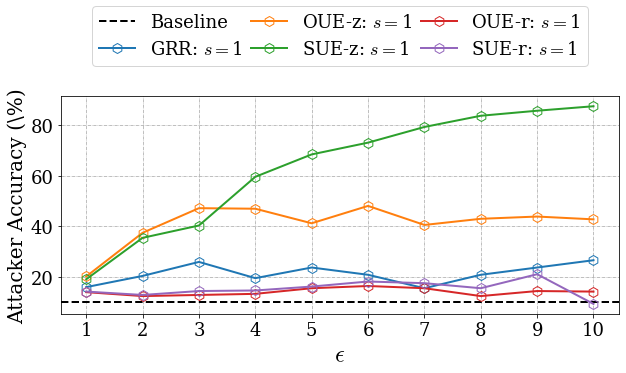

In [19]:
lst_syn = [1] # [1, 3, 5]
nb_seed = 20

plt.figure(figsize=fig_size)
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.axhline(y=(1/d)*100, linewidth=2, color='black', label='Baseline', linestyle ='--')
    
markers = ['h', 's', 'v']

for idx in range(len(lst_syn)):
    attack_grr = pd.read_csv('results/'+dataset+'/attack_NK_s_'+str(lst_syn[idx])+'_rs_fd_grr.csv', header=None, index_col=0).iloc[:nb_seed]
    print(attack_grr.shape)
    plt.plot(range(1,len(lst_eps)+1), attack_grr.mean(), label='GRR: $s=$'+str(lst_syn[idx]), marker=markers[idx], markerfacecolor='none')
    
    attack_oue_z = pd.read_csv('results/'+dataset+'/attack_NK_s_'+str(lst_syn[idx])+'_rs_fd_oue_z.csv', header=None, index_col=0).iloc[:nb_seed]
    plt.plot(range(1,len(lst_eps)+1), attack_oue_z.mean(), label='OUE-z: $s=$'+str(lst_syn[idx]), marker=markers[idx], markerfacecolor='none')
    print(attack_oue_z.shape)
    
    attack_sue_z = pd.read_csv('results/'+dataset+'/attack_NK_s_'+str(lst_syn[idx])+'_rs_fd_sue_z.csv', header=None, index_col=0).iloc[:nb_seed]
    plt.plot(range(1,len(lst_eps)+1), attack_sue_z.mean(), label='SUE-z: $s=$'+str(lst_syn[idx]), marker=markers[idx], markerfacecolor='none')
    print(attack_sue_z.shape)
    
    attack_oue_r = pd.read_csv('results/'+dataset+'/attack_NK_s_'+str(lst_syn[idx])+'_rs_fd_oue_r.csv', header=None, index_col=0).iloc[:nb_seed]
    plt.plot(range(1,len(lst_eps)+1), attack_oue_r.mean(), label='OUE-r: $s=$'+str(lst_syn[idx]), marker=markers[idx], markerfacecolor='none')
    print(attack_oue_r.shape)
    
    attack_sue_r = pd.read_csv('results/'+dataset+'/attack_NK_s_'+str(lst_syn[idx])+'_rs_fd_sue_r.csv', header=None, index_col=0).iloc[:nb_seed]
    plt.plot(range(1,len(lst_eps)+1), attack_sue_r.mean(), label='SUE-r: $s=$'+str(lst_syn[idx]), marker=markers[idx], markerfacecolor='none')
    print(attack_sue_r.shape)
    
    plt.xlabel('$\epsilon$', fontsize=font_x)
    plt.ylabel('Attacker Accuracy (\%)', fontsize=font_y)
    plt.xticks(range(1,len(lst_eps)+1), lst_eps)
    idx+=1
plt.legend(bbox_to_anchor=(0.5, 1.1), columnspacing=0.5, ncol=3, loc='lower center')
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

Please execute with more seeds for more stable plots